### James Griffin 
#### Irrigation  EDA 
#### Stat 536

IRRIGATED AGRICULTURE

Irrigation has been developed to allow stable, high yield agriculture and avoid the effects of drought. However, water scarcity in many regions of the US is a problem due to declining ground- water levels, increasing competition for water by municipal and industrial users, and increasing frequency and severity of drought. In a water-limited setting, the most promising approach toward a sustainable and cooperative management of water resources is to improve agricultural water productivity. That is, produce more crop for every drop of water. -- increase the marginal benefit of water in terms of prodution

The crop water stress index (CWSI) is a widely used indicator that provides an estimate of the crop water status. The CWSI is measured using widely available surface temperature thermometers (e.g. remote sensing devices). CWSI values near 1 indicate a high stress environment for the crop wherein water needs to be added. Likewise, CWSI near 0 indicate that a crop is well hydrated. By measuring CWSI across a crop field, for example, farmers are able to know when their crops require watering and, hence, can better manage their water resources by not adding water until necessary.

While CWSI is useful for knowing when to apply water, it does not indicate how much water to add. Knowing how much water to add requires knowledge of the soil water content (SWC; the amount of water present in the soil). Measuring SWC, in contrast to CWSI, is expensive. However, if a unique relationship could be established between CWSI and SWC then CWSI could be used to understand SWC and, subsequently, manage the amount of water used by the farmer. Specifically, farmers want to know how much water to add at given levels of CWSI.
For this analysis, I wish you to answer the following questions:

1. What is the predictive capability of CWSI in predicting SWC?
2. Given a CWSI measurement of 0.5, approximately how much water needs to be added to bring the SWC up to full capacity (29)?

In [55]:
#importing 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import warnings; warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('../data/irrigation_data.csv')
data = data.drop(columns = ['Unnamed: 0'])
data.head()

,CWSI,SWC
0,0.020,28.77
1,0.044,28.34
2,0.056,28.16
3,0.050,27.61
4,0.077,27.23


Ok so this presents a couple of hard challenges, the length of the entire data set 44, so we only have 44 observations, which is  not a lot to train with, and from class, Dr Heaton said that this data is also non linear. And we only have 1 feature and the outcome, so peanalized regression doesn't do us a whole lot, clustering doesn't do anything, I'm trying to think of how to answer the first question, of how well does CWSI predict SWC. 

Lets visualize the data a bit 

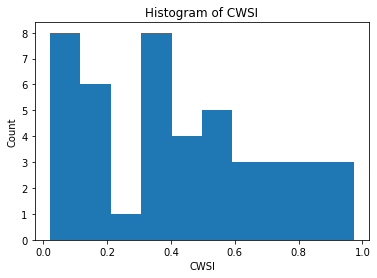

In [3]:
plt.title("Histogram of CWSI")
plt.hist(data.CWSI)
plt.xlabel("CWSI")
plt.ylabel("Count")
plt.show()

another challenge is that is between (0,1) so the varience in CWSI is really low

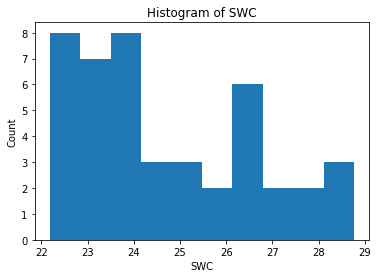

In [4]:
plt.title("Histogram of SWC")
plt.hist(data.SWC)
plt.xlabel("SWC")
plt.ylabel("Count")
plt.show()

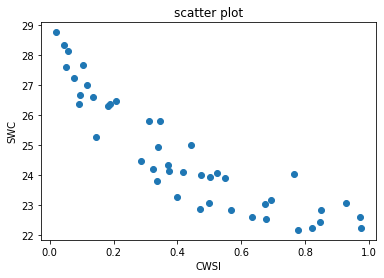

In [5]:
plt.scatter(x = data.CWSI, y = data.SWC)
plt.xlabel("CWSI")
plt.ylabel("SWC")
plt.title("scatter plot")
plt.show()

In [6]:
# ok that is actually not as bad as I thought, that's not super non linear, I mean there's definently a
#shape there so while it might not work linearly, it could work in some other way, I think I'll try to 
# a simple random forest, although I have lots of caviats as  to  why this  probably wont work  super  well
#but ok here  we go 

In [58]:
def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""

    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)

    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept

    #Plot trendline
    plt.plot(xl, yl, c, alpha=alpha)

    #Calculate R Squared
    p = np.poly1d(coeffs)

    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot

    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr


def train_predict(df):
    target = df["SWC"]
    #target = norm['total compensation']
    X = df['CWSI']
    
    #splitting into train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, 
                                                    random_state=17)
    print(X_train.shape)
    X_train = np.array(X_train).reshape(-1,1)
    print(len(y_train))
    xclass = xgb.XGBRegressor()
    rf2 = RandomForestRegressor()
    '''  
    parameters = {
        'learning_rate': [.01, .02, .03, .04, .05], # np.arange(.01, 1, .01), #LOOK AT INCREASING STEP SIZES
        'max_depth': [5, 10, 15, 20, 25,], #np.arange(1, 100, 1), #
        'min_child_samples': [1, 2, 3], #np.arange(1, 15, 2), #,
        'subsample': np.arange(.3, .7, .1),
        'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :[50, 100, 150, 200, 250, 300, 350, 400,], #np.arange(100, 1200, 100), #
        #'objective': ['reg:squarederror'],  
        }'''
 
    parameters = {
        #'learning_rate': [.01, .02, .03, .04, .05], # np.arange(.01, 1, .01), #LOOK AT INCREASING STEP SIZES
        'min_samples_split': [1,2,3,],
        'max_depth': [5, 10, 15, 20, 25,], #np.arange(1, 100, 1), #
        #'min_child_samples': [1, 3, 5], #np.arange(1, 15, 2), #,
        'min_samples_leaf': [1, 2, 3],
        #'subsample': np.arange(.3, .7, .1),
        #'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :[25, 50, 75, 100, 150, 200, 250], #np.arange(100, 1200, 100), #
        #'objective': ['reg:squarederror'],  
        }
    gs = RandomizedSearchCV(rf2, parameters, cv = 3)
    gs.fit(X_train, y_train)

    #looking at how we did 
    X_test = np.array(X_test).reshape(-1,1)
    boost_preds = gs.predict(X_test)
    print(boost_preds)
    mse_rf_xgb = (mean_squared_error(boost_preds, y_test))**(1/2)
    print("overall RMSE")
    print(mse_rf_xgb)  
    print(" ")

    #plt.scatter(x = rf_pred2, y = np.e**y_val, color = "blue")
    plt.scatter(x = y_test, y = boost_preds, color = "lightgreen")
    plt.title("random foreset CV = 5, CWSI predicting SWC")
    plt.xlabel('true values')
    plt.ylabel("Predicted values by random forest")
    #trendline(rf_pred2, np.e**(y_val))
    trendline(boost_preds, y_test)
    plt.show()
    return gs

(33,)
33
[22.57991429 24.61640762 26.05586905 24.40647619 24.66229095 22.58561429
 22.57991429 22.76051095 22.66459429 22.97863    22.78622762]
overall RMSE
0.7544605641036716
 


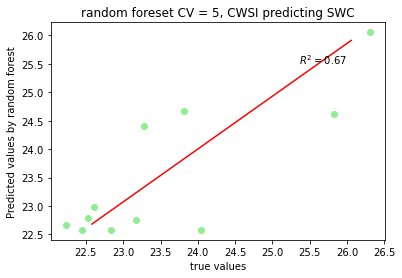

In [59]:
forest = train_predict(data)

yeah  so this didn't work super  great, like its not terrible, for observations beelow about 23.5, it did really well, but after that it was kind of all  over the place. The forest struggled because it only had one input to the model and thus was unable to really learn from different branches and patterns. It would have been better to do some sort of penalized regression. -- so at least this  method,  was CWSI was not a super  great predictor of SWC. althought it is entirely possible that if we were to use a nueral network or something a little more robust that we could get better predictions. It is also possible that CWSI simply does not do a good job of predicting, which would mean to improve we would need more training data and more data in terms of features for the model 

#2 Given a CWSI measurement of 0.5, approximately how much water needs to be added to bring the SWC up to full capacity (29)?

In [61]:
#ok so here is our predition from  our random forest 
pred = np.array(.5).reshape(-1,1)
p = 29-forest.predict(pred)[0]
p

5.561039999999995

In [63]:
rmse = 0.7544605641036716
#so creating a range of possible water necessity 
water = (p-rmse, p+rmse)
water

(4.806579435896324, 6.315500564103666)

this would be our estimage of how much water you would need to add
